In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [1]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import time 
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
## population and age classes
M=4  ## number of age classes

my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

# scale the population down to a more manageble level 
Ni[0] = (np.sum(Ni0[0:4])).astype('int')
Ni[1] = (np.sum(Ni0[4:8])).astype('int')
Ni[2] = (np.sum(Ni0[8:12])).astype('int')
Ni[3] = (np.sum(Ni0[12:16])).astype('int')
N=np.sum(Ni)
fi = Ni/N 

# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.India()


CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))

for i in range(16):
    CH0[i,:] = Ni0[i]*CH0[i,:]
    CS0[i,:] = Ni0[i]*CS0[i,:]
    CW0[i,:] = Ni0[i]*CW0[i,:]
    CO0[i,:] = Ni0[i]*CO0[i,:]

    
for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CW[i,j] = np.sum( CW0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CS[i,j] = np.sum( CS0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CO[i,j] = np.sum( CO0[i1:i1+4,j1:j1+4]  )/Ni[i]
        
N = N/5e2
Ni = Ni/5e2

In [3]:
# Generate class with contact matrix for SIR model with UK contact structure
generator = pyross.contactMatrix.SIR(CH, CW, CS, CO)

In [4]:
times= [20] # temporal boundaries between different contact-behaviour

aW, aS, aO = 0.5, 0.6, 0.6

# prefactors for CW, CS, CO:
interventions = [[1.0,1.0,1.0],      # before first time
                 [aW, aS, aO],       # after first time
                ]         

# generate corresponding contact matrix function
C = generator.interventions_temporal(times=times,interventions=interventions)

In [5]:
beta  = 0.02      # contact rate parameter
gIa   = 1./7            # recovery rate of asymptomatic infectives 
gIs   = 1./7            # recovery rate of symptomatic infectives 
alpha = 0.2              # asymptomatic fraction
fsa   = 0.8               # suppresion of contact by symptomatics


# initial conditions    
Is_0 = np.ones(M)*20
Is_0[1] += 10 #make one group different 
Ia_0 = np.zeros((M))*2
Ia_0[1] += 2 
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)


parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'fsa':fsa}
model = pyross.stochastic.SIR(parameters, M, Ni)

# start simulation
Tf=100;  Nf=Tf+1 
data=model.simulate(S_0, Ia_0, Is_0, C, Tf, Nf)

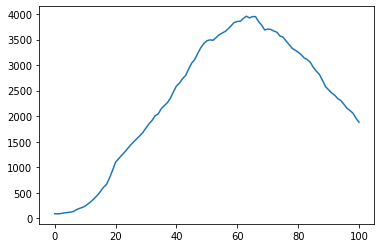

In [6]:
IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i] 
t = data['t']
plt.plot(t, IC)
plt.show() 

-2216.229158026227
0.27049708366394043


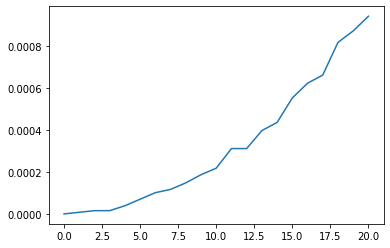

In [7]:
Tf = 20 # truncate to only getting the first few datapoints 
Nf = Tf+1

x = data['X']
x = (x/N)[:Nf]
steps = 101 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, generator.constant_CM)
end_time = time.time()
print(logp) 
print(end_time - start_time)

plt.plot(x[:, M])
plt.show()

In [8]:
# take a guess 
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm 
alpha_g = 0.2
alpha_std = 0.1 
alpha_bounds = (eps, 1-2*eps)
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.04
beta_std = 0.05 
beta_bounds = (eps, 1)

gIa_g = 0.145
gIa_std = 0.1 
gIa_bounds = (eps, 1)

gIs_g = 0.145
gIs_std = 0.1 
gIs_bounds = (eps, 1) 

guess = np.array([alpha_g, beta_g, gIa_g, gIs_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std])
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds])

start_time = time.time() 
params = estimator.inference(guess, stds, x, Tf, Nf, generator.constant_CM, beta_rescale=5,
                                  bounds=bounds, global_max_iter=20,
                                  eps=eps, verbose=True)
# sometimes produce errors if input is bad, ignore and let basinhopping do its magic
end_time = time.time()
print(params) # best guess 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 4 (seed=376683, Thu Apr 30 22:44:06 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -1.957638177883944e+03 1.0e+00 1.53e+00  3e-02  6e-02 0:05.3
    2     32 -2.130458404491042e+03 1.5e+00 2.12e+00  4e-02  7e-02 0:09.4
    3     48 -2.157766088197037e+03 1.5e+00 2.63e+00  4e-02  9e-02 0:13.1
    5     80 -2.210341295501822e+03 1.6e+00 2.12e+00  3e-02  7e-02 0:19.6
    6     96 -2.198002190277618e+03 1.6e+00 1.84e+00  2e-02  6e-02 0:23.7
    8    128 -2.218151083827163e+03 2.3e+00 1.34e+00  1e-02  4e-02 0:30.6
   10    160 -2.222584126996514e+03 2.5e+00 7.59e-01  5e-03  2e-02 0:37.1
   13    208 -2.223086887406838e+03 4.7e+00 4.90e-01  2e-03  1e-02 0:46.7
   16    256 -2.223333208383152e+03 6.2e+00 2.66e-01  7e-04  7e-03 0:55.9
   19    304 -2.223500665984354e+03 7.9e+00 2.45e-01  5e-04  7e-03 1:05.2
Optimal value (global minimisation):  -2223.5338690764306
Startin

In [14]:
aW_g = 0.5 
aW_bounds = [0.1, 0.8]
aS_g = 0.5
aS_bounds = [0.1, 0.8]
aO_g = 0.5
aO_bounds = [0.1, 0.8]
guess = np.array([aW_g, aS_g, aO_g])
bounds = np.array([aW_bounds, aS_bounds, aO_bounds])
stds = np.array([0.1, 0.2, 0.15])

x = data['X']/N
x = x[22:]
Nf = x.shape[0] 
Tf = Nf-1 

times = [Tf+1]
interventions = [[aW, aS, aO]]
contactMatrix = generator.interventions_temporal(times=times,interventions=interventions)

# compute -log_p for the initial guess (for the moment, use correct parameters)
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
print(logp) 

-7631.267753580091


In [16]:
eps = 1e-3 
start_time = time.time() 

parameters = estimator.make_params_dict(params)
estimator.set_params(parameters) 
params = estimator.infer_control(guess, stds, x, Tf, Nf, generator, bounds,
                                 global_max_iter=20, eps=eps, verbose=True)
# sometimes produce errors if input is bad, ignore and let basinhopping do its magic
end_time = time.time()
print(params) # best guess 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 3 (seed=396831, Thu Apr 30 22:55:51 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -7.621974423551511e+03 1.0e+00 1.11e+00  1e-01  1e-01 0:12.8
    2     32 -7.624299476300817e+03 1.4e+00 1.21e+00  1e-01  1e-01 0:26.7
    3     48 -7.634326780201333e+03 1.5e+00 1.11e+00  8e-02  1e-01 0:39.1
    4     64 -7.634745542106241e+03 1.5e+00 1.02e+00  6e-02  9e-02 1:01.6
    5     80 -7.635235096842813e+03 1.8e+00 9.50e-01  4e-02  8e-02 1:23.0
    6     96 -7.634932953966078e+03 2.1e+00 7.57e-01  3e-02  6e-02 1:40.4
    7    112 -7.634877182079054e+03 2.5e+00 6.29e-01  3e-02  5e-02 1:55.1
    8    128 -7.636226188570949e+03 3.3e+00 6.80e-01  3e-02  4e-02 2:07.4
    9    144 -7.635916976647060e+03 3.0e+00 5.60e-01  2e-02  3e-02 2:19.0
   10    160 -7.636395101360845e+03 3.2e+00 5.18e-01  2e-02  3e-02 2:30.9
   11    176 -7.636550477295862e+03 3.4e+00 4.00e-01  1e-02  2e-0